# POD Implementation - Linear Time Invariant Systems (LTI)
## Application to time-dependent heat conduction

Consider a 1D **nonlinear** heat conduction problem
$$ \rho C_p\frac{\partial T}{\partial t} -\frac{\partial x}{\partial x} k(x,t,T)\frac{\partial T}{\partial x} = q(x,t)
$$
where the conductivity, density$\times$specific heat can be functions of temperature, space, and time $k(x,t,T)$, $\rho C_p(x,t,T)$.

**Boundary conditions**:
Generally, on the boundary, one may have :
* a natural boundary condition $$ a(t) T + k\partial_n T = c(t)$$
* or a fixed, imposed value $$ T(t) = \text{given}(t)$$

Examples:
- reflective at $x=0$: $\quad \left.\tfrac{dT}{dx}\right|_0 = 0$
- imposed temperature (Dirichlet bc) at $x=L$: $\quad T(L,t)=T_{bc}(t)$
- convective heat transfer boundary value can be written as:
  $$
  -k\partial_n T  = h(t)(T - T^{\infty}(t))
  $$
  So $a(t)=h(t)$, the convective heat exchange coefficient, and $c(t)=h(t) T^\infty(t)$, with $T^\infty(t)$ the far-field cooling temperature.

**Initial condictions conditions**:
Often, $T(x,t=0)=T_0(x)$.

**Linear version** of the problem: set $k(x,t,T)=k(x,t)$, $\rho C_p(x,t,T)=\rho C_p(x,t)$

**Linear and time-invariant version** of the problem: set $k(x,t,T)=k(x)$, $\rho C_p(x,t,T)=\rho C_p(x)$, $a(t)=a$, $c(t)=c$.


### Linear version of the problem: system matrix

One way the discrete expression can be obtained is by integrating the governing equation for $x \in [x_{i-1/2},x_{i+1/2}]$:

$$
\int_{x_{i-1/2}}^{x_{i+1/2}}dx\, \left(\rho C_p(x) \frac{\partial  T}{\partial  t} -\frac{\partial }{\partial x} k(x)\frac{\partial T}{\partial x} = q(x,t) \right)
$$

Thus, we obtain a **vertex-centered** simple finite difference:

$$
\left(\frac{\rho C_{p,i+1/2}\Delta x_{i+1/2}}{2} + \frac{\rho C_{p,i-1/2}\Delta x_{i-1/2}}{2}\right) \frac{d T_i}{dt}
-k_{i+1/2}\frac{T_{i+1}-T_i}{\Delta x_{i+1/2}}
+
k_{i-1/2}\frac{T_i-T_{i-1}}{\Delta x_{i-1/2}}
=
\frac{q_{i+1/2}\Delta x_{i+1/2}}{2} + \frac{q_{i-1/2}\Delta x_{i-1/2}}{2}
$$

where the full integer indices denote nodal (vertex) values and the half-integer indices denote cell values. $\Delta x_{i+1/2}=x_{i+1}-x_i$.

This yields the following system of equations (ODEs):
$$ D\frac{d T}{dt} =-\hat A T(t) + \hat b(t)$$
that you can re-write as ($D$ is diagonal so the action of $D^{-1}$ is easy to apply)
$$\frac{d T}{dt} = -A T(t) +  b(t)$$



### load python modules

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg
import time

# 1-D slab mesh and material properties
We give material properties "per zone" and then replicate them as many times as needed to assign them to a mesh cell (mesh resolution is a refinement of the material zone layout).

In [55]:
def create_slab_mesh(n_ref,zone_widths):
    # input: 
    #    n_ref: integer (how many times each zone is to be refined)
    #    zone_widths: array of zone widths
    # output:
    #    x: array of cell interface positions
    #    dx: array of cell widths
    #    cell2mat: given a cell index, this returns the material ID in that cell
    
    if len(zone_widths) != len(n_ref):
        raise ValueError("dx and nref should have same length")
    
    # compute cell widths
    dx = np.repeat(zone_widths/n_ref, n_ref)
    
    # cell interfaces
    x = np.zeros(len(dx)+1)
    for i in range(len(dx)):
        x[i+1] = x[i] + dx[i]
        
    # create cell2mat array
    cell2mat = np.repeat( np.arange(len(zone_widths)), n_ref)
    
    # middle point
    xm = 0.5 * (x[1:]+x[:-1])
    
    return x, xm, dx, cell2mat

# build linear system matrix

In [56]:
def build_matrix_at_once(rhocp_arr, cond_arr, bc, xm, dx, mat2cell):
    # input: 
    #    cond_arr: conductivity array (length = number of material zones)
    #    xm   : array of cell middle points (length = number of cells)
    #    dx   : array of cell widths (length = number of cells)
    #    cell2mat: given a cell index, this returns the material ID in that cell
    # output:
    #    K: matrix

    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1
    
    # evaluate mat property per cell
    cond_ = cond_arr[mat2cell]
    rhocp_ = rhocp_arr[mat2cell]
    cond = np.zeros(n_cells)
    rhocp = np.zeros(n_cells)
    for i,(kfunc,rhocpfunc,xmiddle) in enumerate(zip(cond_,rhocp_,xm)):
        cond[i] = kfunc(xmiddle)
        rhocp[i] = rhocpfunc(xmiddle)
    
    # matrix
    K = sparse.lil_matrix((n_pts,n_pts))
    Diag = sparse.lil_matrix((n_pts,n_pts))
    for i in range(0,n_pts):
        if i>0:
            K[i,i-1] = -cond[i-1]/dx[i-1]
            K[i,i  ] = cond[i-1]/dx[i-1]
            Diag[i,i]   = rhocp[i-1]*dx[i-1]/2
        if i<n_pts-1:
            K[i,i+1] = -cond[i  ]/dx[i  ]
            K[i,i  ]+= cond[i]/dx[i]
            Diag[i,i]  += rhocp[i]*dx[i]/2

    # apply left bc
    if bc["left"]["type"] == "natural":
        K[0,0] += bc["left"]["value_a"]
    elif bc["left"]["type"] == "dirichlet":
        raise ValueError("code not tested for Dirichlet left")
        K[0,:2] = 0.
        K[0,0]  = 1.
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        K[-1,-1] += bc["right"]["value_a"]
    elif bc["right"]["type"] == "dirichlet":
        raise ValueError("code not tested for Dirichlet right")
        K[-1,-2:] = 0.
        K[-1,-1]  = 1.
    else:
        raise ValueError("unknown bc type on right")

    return Diag.tocsc(),K.tocsc()

# build linear system rhs

In [57]:
def build_rhs_at_once(qext_arr, bc, xm, dx, mat2cell):
    # number of cells, points
    n_cells = len(dx)
    n_pts   = n_cells + 1

    # evaluate src property per cell
    qext_  = qext_arr[mat2cell]
    rhocp_ = rhocp_arr[mat2cell]
    qext  = np.zeros(n_cells)
    rhocp = np.zeros(n_cells)
    for i,(qfunc,xmiddle) in enumerate(zip(qext_,xm)):
        qext[i]  = qfunc(xmiddle)
    
    #  rhs
    rhs = np.zeros(n_pts)
    rhs[:-1] += qext*dx/2
    rhs[1:]  += qext*dx/2
    
    # apply left bc
    if bc["left"]["type"] == "natural":
        rhs[0] += bc["left"]["value_c"]
    elif bc["left"]["type"] == "dirichlet":
        raise ValueError("code not tested for Dirichlet left")
        rhs[0] = bc["left"]["value"]
    else:
        raise ValueError("unknown bc type on left")
        
    # apply right bc
    if bc["right"]["type"] == "natural":
        rhs[-1] += bc["right"]["value_c"]
    elif bc["right"]["type"] == "dirichlet":
        raise ValueError("code not tested for Dirichlet right")
        rhs[-1] = bc["right"]["value"]
    else:
        raise ValueError("unknown bc type on right")

    return rhs

## 2 materials, mat prop are piece-wise constant and time-independent, external source is piece-wise constant and time-dependent

In [58]:
# rho-cp functions per zone
rhocp_arr = []
rhocp_arr.append( lambda x: 10 + 0.*x)
rhocp_arr.append( lambda x: 100 + 0.*x)
rhocp_arr = np.asarray(rhocp_arr)

# conductivity functions per zone
cond_arr = []
cond_arr.append( lambda x: .5 + 0.*x)
cond_arr.append( lambda x: 5 + 0.*x)
cond_arr = np.asarray(cond_arr)

# external volumetric heat source functions per zone
qext_arr = []
qext_arr.append( lambda x: 150 + 0.*x)
qext_arr.append( lambda x: 150 + 0.*x)
qext_arr = np.asarray(qext_arr)

# geometry
width   = np.array([ 1., 1.])
n_ref = np.array([30, 15], dtype=int)

x, xm, dx, mat2cell = create_slab_mesh(n_ref, width)

# boundary conditions
bc = {}
h = 100.
Tinf = 20.
bc_hco = {"type": "natural"  , "value_a": h, "value_c": h*Tinf}
bc_sym = {"type": "natural"  , "value_a": 0., "value_c": 0.}

bc["left"]  = bc_hco
bc["right"] = bc_sym
bc["right"] = bc_hco

# build linear system
Diag,K = build_matrix_at_once(rhocp_arr, cond_arr, bc, xm, dx, mat2cell)
rhs = build_rhs_at_once(qext_arr, bc, xm, dx, mat2cell)

In [59]:
# plt.figure()
# plt.spy(D)
# plt.figure()
# plt.spy(K)
# plt.figure()
# plt.plot(rhs)

(201,)
(46, 201)


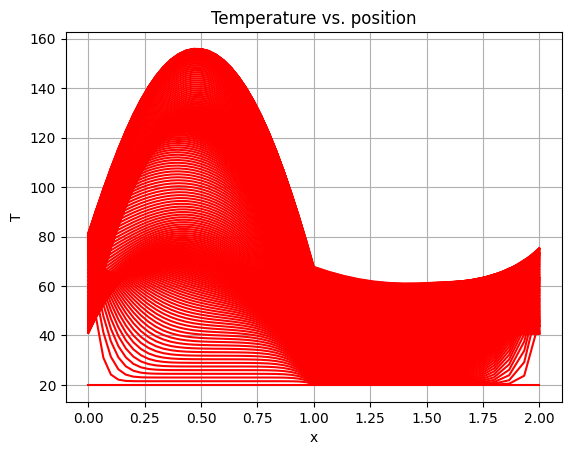

In [60]:
from scipy.integrate import solve_ivp
import time as time
import matplotlib.animation as animation

# prepare for dT/dt = -AT + b
Dinv = linalg.inv(Diag)
A = Dinv @ K
b = Dinv @ rhs

def FOM_function(t,u,A,b):
    return -A@u + b * excitation(t)
#     return -A@u + b *  (1-np.exp(-t)) * np.cos(np.pi * t)

# definition excitation of the heat source 
def excitation(t):
    return (3 + 1*np.cos(np.pi * t))

# initial flat temperature
Tinit = np.zeros(len(b)) + 20.

# solve the ODE
rtol_=1e-5
atol_=1e-5
Tend = 5.
ntimes= 201
t_events = np.linspace(0,Tend,ntimes)

FOM = solve_ivp(FOM_function, [0, Tend], Tinit, t_eval=t_events, args=(A,b), \
                rtol=rtol_, atol=atol_, method='Radau')
print(FOM.t.shape)
print(FOM.y.shape)

# plots all snapshots
plt.figure()
for it,t in enumerate(FOM.t):
    plt.plot(x,FOM.y[:,it],'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position')
plt.grid(True)
plt.show()

In [61]:
# # Enable interactive plot
# %matplotlib notebook

# from IPython.display import HTML
# from IPython.display import display

# fig, ax = plt.subplots()
# ax.set_xlabel('x')
# ax.set_ylabel('T')
# plotLine, = ax.plot(x, np.zeros(len(x))*np.NaN, 'r-')
# plotTitle = ax.set_title("t=0")
# # ax.set_ylim(0,1.)
# ax.set_xlim(x[0],x[-1])
# ax.set_ylim(np.min(sol.y)-2,np.max(sol.y)+2)

# def animate(it):
#     pp = FOM.y[:,it]
#     plotLine.set_ydata(pp)
#     plotTitle.set_text(f"t = {sol.t[it]:.1f}")
#     #ax.relim() # use if autoscale desired
#     #ax.autoscale()
#     return [plotLine,plotTitle]

# anim =animation.FuncAnimation(fig, func=animate, frames=np.arange(0,ntimes,1), blit=True)
# # HTML(anim.to_html5_video())
# display(HTML(anim.to_jshtml()))

# %matplotlib inline
# ?%matplotlib 

## POD for Linear Systems 

##### Compute POD basis

In [62]:
# data matrix (collected snapshots)
X = np.copy(FOM.y)
print("Rank of data matrix = {0} --> so there will be at most {0} SV's".format(np.linalg.matrix_rank(X)))

Rank of data matrix = 30 --> so there will be at most 30 SV's


Shapes:
	U (46, 46)
	Sigma (46,)
	Vh (46, 201)


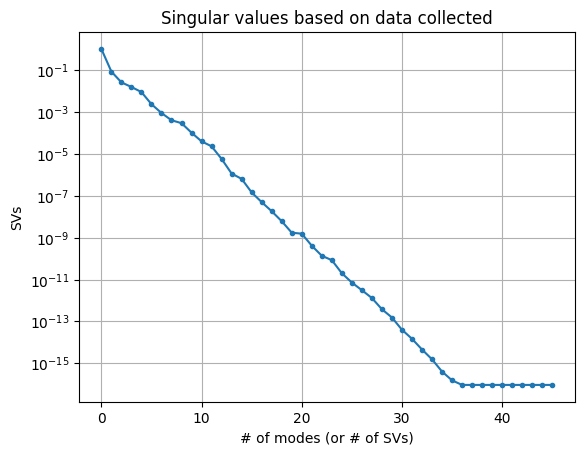

In [63]:
from scipy.linalg import svd

U, Sigma, Vh = svd(X, full_matrices=False)

print("Shapes:\n\tU {}\n\tSigma {}\n\tVh {}".format(np.shape(U),np.shape(Sigma),np.shape(Vh)))

plt.semilogy(Sigma/Sigma[0],'.-')
plt.title('Singular values based on data collected')
plt.xlabel('# of modes (or # of SVs)')
plt.ylabel('SVs')
plt.grid(True)
plt.show()

##### Select Truncation - look at SVD or Energy

In [64]:
r = 3
print("at truncated rank={}, Sigma_r/Sigma_0 = {} is small".format(r,Sigma[r]/Sigma[0]))

at truncated rank=3, Sigma_r/Sigma_0 = 0.015333349577129615 is small


### Perform Projection using POD-Galerkin


(201,)
(3, 201)


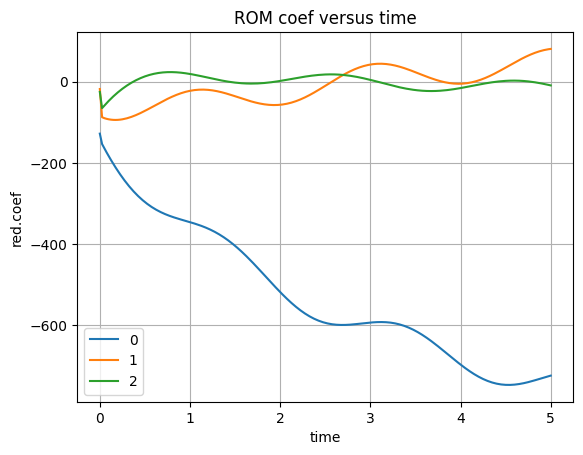

In [65]:
Ur = U[:, :r]
Ar = Ur.T @ A @ Ur
br = Ur.T @ b

# not really needed as it is the same function as FOM_function.
# only the A and b passed as arguments change
def ROM_function(t,u,A,b):
    return -A@u + b * excitation(t)

# solve ODE
# note that initial condition is also projected !!
ROM = solve_ivp(ROM_function, [0, Tend], Ur.T @ Tinit, t_eval=t_events, args=(Ar,br), \
                rtol=rtol_, atol=atol_, method='Radau')
print(ROM.t.shape)
print(ROM.y.shape)

plt.figure()
for ir in range(r):
    plt.plot(t_events,ROM.y[ir,:],label=str(ir))
plt.xlabel('time')
plt.ylabel('red.coef')
plt.title('ROM coef versus time')
plt.legend()
plt.grid(True)
plt.show()

### Reconstruct Approximate FOM States

In [66]:
print("shape of the expansion coefficients:",ROM.y.shape)

shape of the expansion coefficients: (3, 201)


shape of the reconstructed full solution: (46, 201)


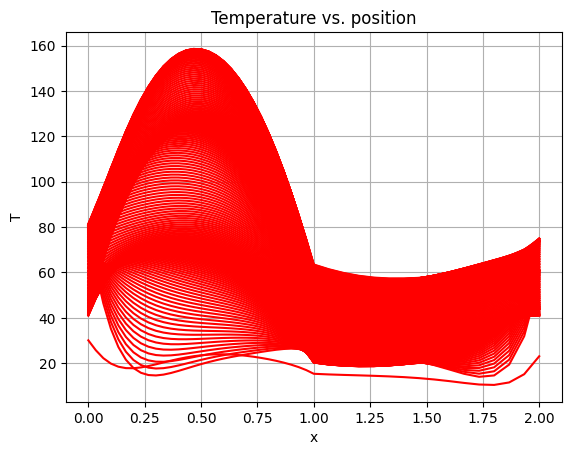

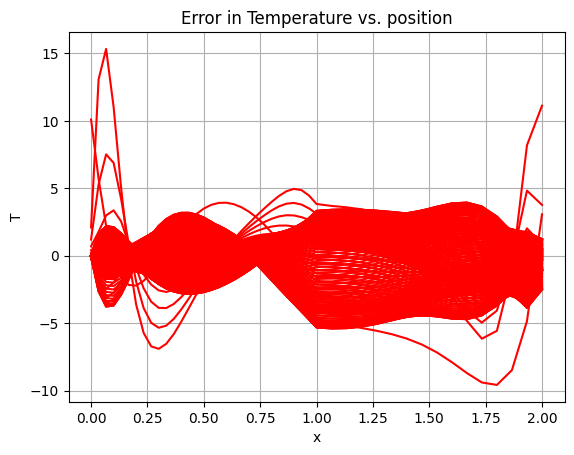

measurements made at [ 9 18 27 36]


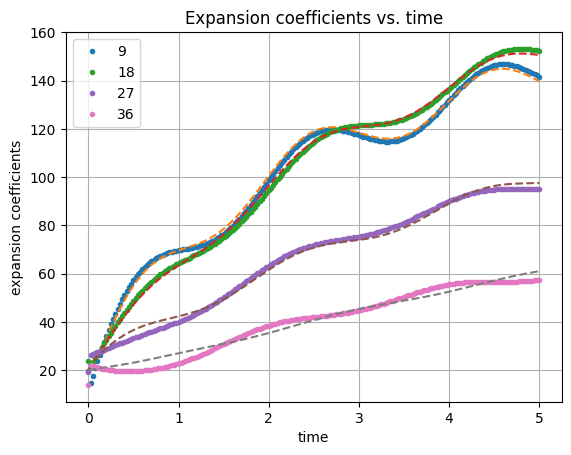

In [67]:
# Reconstructed States
reconst_FOM = Ur @ ROM.y
print("shape of the reconstructed full solution:",reconst_FOM.shape)

plt.figure()
for it,t in enumerate(FOM.t):
    plt.plot(x,reconst_FOM[:,it],'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Temperature vs. position')
plt.grid(True)
plt.show()


plt.figure()
for it,t in enumerate(FOM.t):
    plt.plot(x,reconst_FOM[:,it]-FOM.y[:,it],'r')
plt.xlabel('x')
plt.ylabel('T')
plt.title('Error in Temperature vs. position')
plt.grid(True)
plt.show()

# pick a few points: the vertices at about 20%, 40%, 60%, and 80% of the solution vector
# these are like measurement points
pos=np.floor(len(x)*np.array([0.2,0.4,0.6,0.8])).astype(int)
print("measurements made at",pos)

plt.figure()
for p in pos:
    plt.plot(t_events,reconst_FOM[p,:],'.',label=str(p))
    plt.plot(t_events,FOM.y[p,:],'--')
plt.xlabel('time')
plt.ylabel('expansion coefficients')
plt.legend()
plt.title('Expansion coefficients vs. time')
plt.grid(True)
plt.show()

# Connection to Gramians

In [68]:
#!pip install control
import numpy as np
import control as ctrl
import time

system size =  46


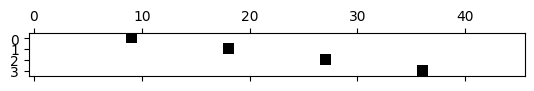

Shape of A: (46, 46)
Shape of B: (46, 1)
Shape of C: (4, 46)
Shape of D: (4, 1)
[[0.]
 [0.]
 [0.]
 [0.]]


In [87]:
print("system size = ",len(b))

# build C
C = np.zeros((len(pos),len(b)))
for i,p in enumerate(pos):
    C[i,p]=1
plt.figure()
plt.spy(C)
plt.show()


# build B
B = np.copy(b)
B = np.expand_dims(B,axis=1)

# build D
D = np.zeros((len(pos),1))

print("Shape of A:",A.shape)
print("Shape of B:",B.shape)
print("Shape of C:",C.shape)
print("Shape of D:",D.shape)

# Generating state-space system
sys = ctrl.ss(-A.toarray(),B,C,D)
print(D)

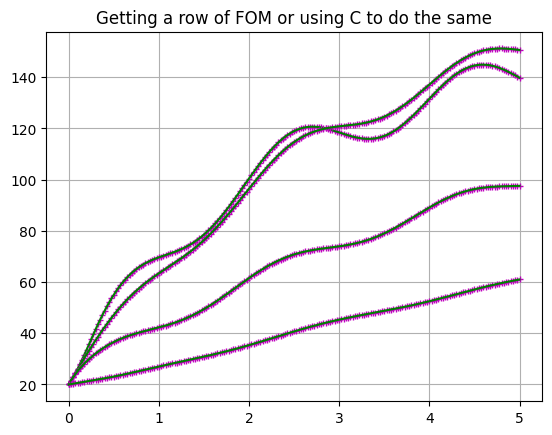

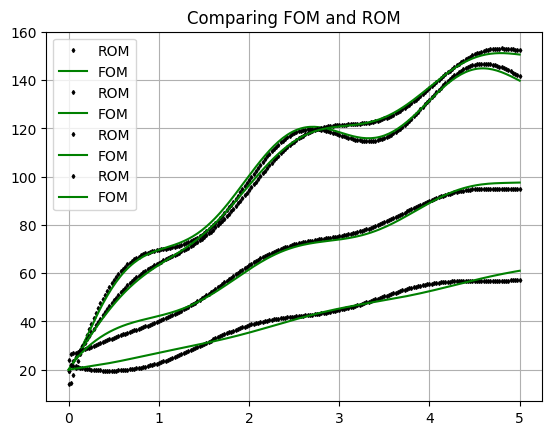

In [88]:
for p in range(len(pos)):
    plt.plot(t_events,FOM.y[pos[p],:],'m+',ms=4)
    plt.plot(t_events,C[p,:]@FOM.y,'g',ms=1)
plt.title('Getting a row of FOM or using C to do the same')
plt.grid(True)
plt.show()

for p in range(len(pos)):
    plt.plot(t_events,reconst_FOM[pos[p],:],'kd',ms=2,label='ROM')
    plt.plot(t_events,C[p,:]@FOM.y,'g',ms=1,label='FOM')
plt.title('Comparing FOM and ROM')
plt.grid(True)
plt.legend()
plt.show()

### Simulate the LTI-System with "balred"

In [89]:
t_events2 = np.linspace(0,Tend,200)
T,yout,states = ctrl.forced_response(sys, T=t_events2, U=excitation(t_events2), X0=Tinit, return_x=True)

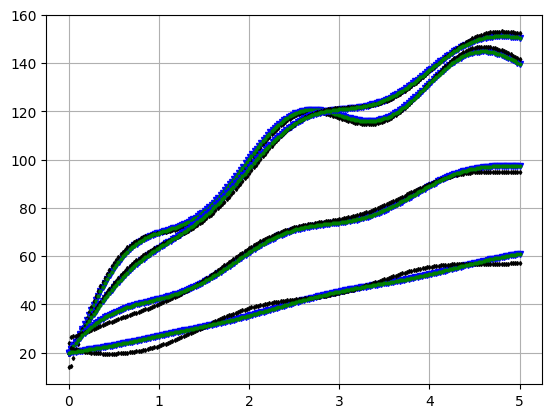

In [90]:
for p in range(len(pos)):
    plt.plot(T,yout[p,:],'bv',ms=4)
#     plt.plot(T,states[pos[p],:],'r.',ms=1)
    plt.plot(t_events,reconst_FOM[pos[p],:],'kd',ms=2)
    plt.plot(t_events,C[p,:]@FOM.y,'go',ms=2)
plt.grid(True)
plt.show()

In [91]:
states.shape

(46, 200)

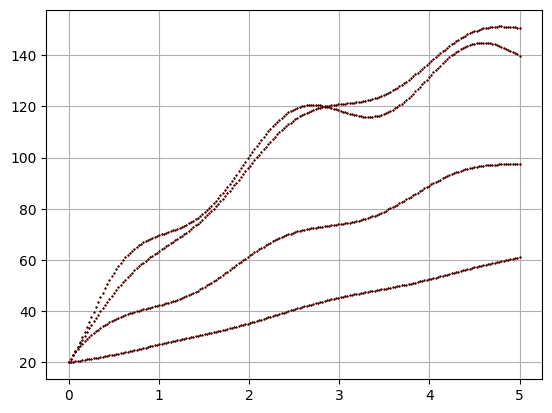

In [92]:
for p in range(len(pos)):
    plt.plot(T,yout[p,:],'r.',ms=1)
    plt.plot(T,states[pos[p],:],'k.',ms=1)
plt.grid(True)
plt.show()

 I had to install: conda install -c conda-forge slycot

In [96]:
sys_red = ctrl.balred(sys,orders=2,method='truncate')

In [97]:
sys_red

StateSpace(array([[-0.21727864,  0.1102166 ],
       [ 0.24954077, -0.41372705]]), array([[-4.91210829],
       [ 3.07756879]]), array([[-3.01826085,  2.64754513],
       [-3.09681163,  1.01047765],
       [-2.01378585, -0.40770396],
       [-1.17189315, -1.12900259]]), array([[0.],
       [0.],
       [0.],
       [0.]]))

In [98]:
type(sys_red)

control.statesp.StateSpace

In [85]:
# build C
C = np.zeros((1,len(b)))
C[0,pos[0]]=1

# build B
B = np.copy(b)
B = np.expand_dims(B,axis=1)

# build D
D = np.zeros((1,1))

print("Shape of A:",A.shape)
print("Shape of B:",B.shape)
print("Shape of C:",C.shape)
print("Shape of D:",D.shape)

# Generating state-space system
sys2 = ctrl.ss(-A.toarray(),B,C,D)

sys2freq = ctrl.ss2tf(sys2)

Shape of A: (46, 46)
Shape of B: (46, 1)
Shape of C: (1, 46)
Shape of D: (1, 1)


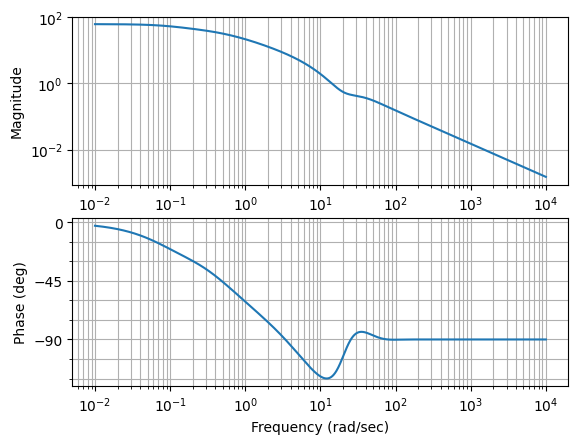

In [86]:
Gmag, Gphase, Gomega = ctrl.bode_plot(sys2freq)